<img src="newlogomioti.png" style="height: 100px">
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura: Machine learning 2: Unsupervised learning</center>

# Challenge S5: Clusterización II

## Plan de expansión: apertura de nuevas tiendas

Una cadena de supermercados desea identificar áreas en las que abrir nuevos centros.

Utilizando información censal (tabla CENSUS2000) el objetivo es encontrar áreas cuyos perfiles de clientes se adapten a diferentes tipologías de centros: boutiques, supermercados de presupuesto medio, grandes superficies, etc.

Se supone que el país tiene una densidad muy baja de establecimientos comerciales y se puede seguir abriendo tiendas en las diferentes regiones.

<img src="tienda.jpg">

## Configuración del entorno

Es recomendable declarar en un bloque al inicio todos los paquetes que vas a utilizar en este notebook:

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

### Información del dataset Census2000
Como hemos mencionado, vamos a hacer uso de un dataset con información censal (tabla CENSUS2000).

Las variables de las que dispone son:  

* Numrow: Numero de fila
* ID: Identificador del registro
* LocX y LocY para geolocalizar las zonas
* RegDens: Densidad de población de la región
* RegPop: Número de habitantes de la región
* MedHHInc: Nivel de ingresos medio de la unidad familiar
* MeanHHSz: Tamaño medio de la unidad familiar (HH = Household)

Los datos se encuentran en un fichero `csv` llamado `census2000.csv`.

Carga los datos en un dataframe para hacer los ejercicios de este bloque.

In [2]:
dfc=pd.read_csv("census2000.csv")

Una vez cargados los datos debemos inspeccionarlos antes de empezar nuestro análisis.

In [3]:
dfc.head()

,Numrow,ID,LocX,LocY,RegDens,RegPop,MedHHInc,MeanHHSz
0,0,00601,-66.749472,18.180103,70.0,19143.0,9888.0,3.24
1,1,00602,-67.180247,18.363285,83.0,42042.0,11384.0,3.10
2,2,00603,-67.134224,18.448619,86.0,55592.0,10748.0,2.84
3,3,00604,-67.136995,18.498987,83.0,3844.0,31199.0,3.00
4,4,00606,-66.958807,18.182151,65.0,6449.0,9243.0,3.20


¿Cuantos registros y columnas tiene el dataset?

¿De que tipo son los datos cargados?

In [4]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33178 entries, 0 to 33177
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Numrow    33178 non-null  int64  
 1   ID        33178 non-null  object 
 2   LocX      33178 non-null  float64
 3   LocY      33178 non-null  float64
 4   RegDens   32165 non-null  float64
 5   RegPop    33178 non-null  float64
 6   MedHHInc  33178 non-null  float64
 7   MeanHHSz  33178 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 2.0+ MB


In [5]:
dfc.describe()

,Numrow,LocX,LocY,RegDens,RegPop,MedHHInc,MeanHHSz
count,33178.000000,33178.000000,33178.000000,32165.000000,33178.000000,33178.000000,33178.000000
mean,16588.500000,-91.084343,38.830389,50.500016,8596.977395,38248.093857,2.500710
std,9577.807952,15.070689,5.359397,28.865519,12978.758221,17469.135891,0.595747
min,0.000000,-176.636755,17.962234,1.000000,0.000000,0.000000,0.000000
25%,8294.250000,-97.219483,35.383955,26.000000,656.000000,28903.750000,2.360000
50%,16588.500000,-88.308757,39.460478,51.000000,2515.000000,35762.000000,2.550000
75%,24882.750000,-80.380665,42.105602,75.000000,11167.500000,45229.250000,2.740000
max,33177.000000,-65.292575,71.299525,100.000000,144024.000000,200001.000000,8.490000


## Filtrado de datos
Una particularidad de este dataset es que contiene información sobre hogares que no tiene miembros en la unidad familiar. Cuantos registros se tienen con unidades familiares iguales o superiores a 1?:

In [6]:
filtro_unidad_familiar  = dfc['MeanHHSz'] >=1
filtro_unidad_familiar.value_counts()

True     32079
False     1099
Name: MeanHHSz, dtype: int64

In [7]:
filtro_unidad_familiar2  = dfc['MeanHHSz'] >=2
filtro_unidad_familiar2.value_counts()

True     30899
False     2279
Name: MeanHHSz, dtype: int64

En este caso vamos a trabajar sólo con aquellos registros con unidades familiares mayores o iguales que 2, para ello tienes que filtrar los datos y quedarte solo con dichos datos.

In [8]:
dfc_filtered = dfc.copy()

dfc_filtered = dfc_filtered[dfc_filtered['MeanHHSz'] >= 2]
dfc_filtered.head()

,Numrow,ID,LocX,LocY,RegDens,RegPop,MedHHInc,MeanHHSz
0,0,00601,-66.749472,18.180103,70.0,19143.0,9888.0,3.24
1,1,00602,-67.180247,18.363285,83.0,42042.0,11384.0,3.10
2,2,00603,-67.134224,18.448619,86.0,55592.0,10748.0,2.84
3,3,00604,-67.136995,18.498987,83.0,3844.0,31199.0,3.00
4,4,00606,-66.958807,18.182151,65.0,6449.0,9243.0,3.20


De esta manera hemos filtrado los datos y podemos ver el resultado:

## Visualización de los datos
Para hacernos una idea de los datos podemos generar algunos gráficos con las principales características de los datos. Podemos utilizar gráficos de barras, sectores, histograma de frecuencias.

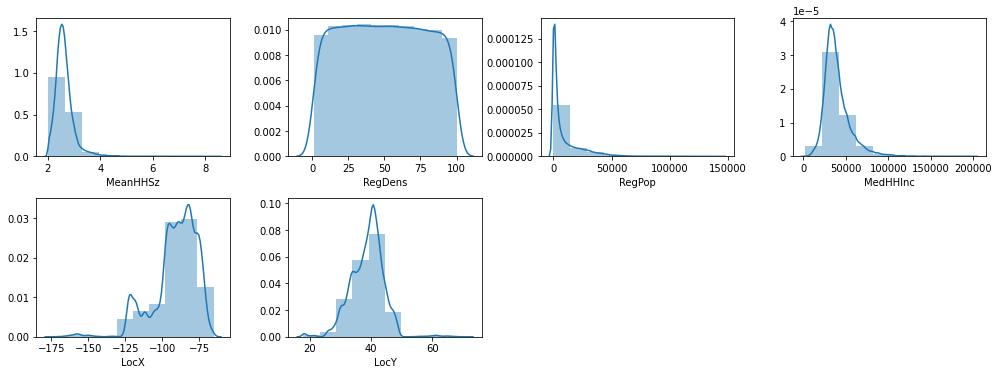

In [9]:
dfc_filtered_graph = dfc_filtered[['MeanHHSz','RegDens','RegPop','MedHHInc','LocX','LocY']]
fig, ax = plt.subplots(figsize = (14, 50))
for i, col in enumerate(dfc_filtered_graph.columns):
    plt.subplot(20, 4, i+1)
    sns.distplot(dfc_filtered_graph.iloc[:,i],bins=10)
    plt.axis('on')
plt.tight_layout()

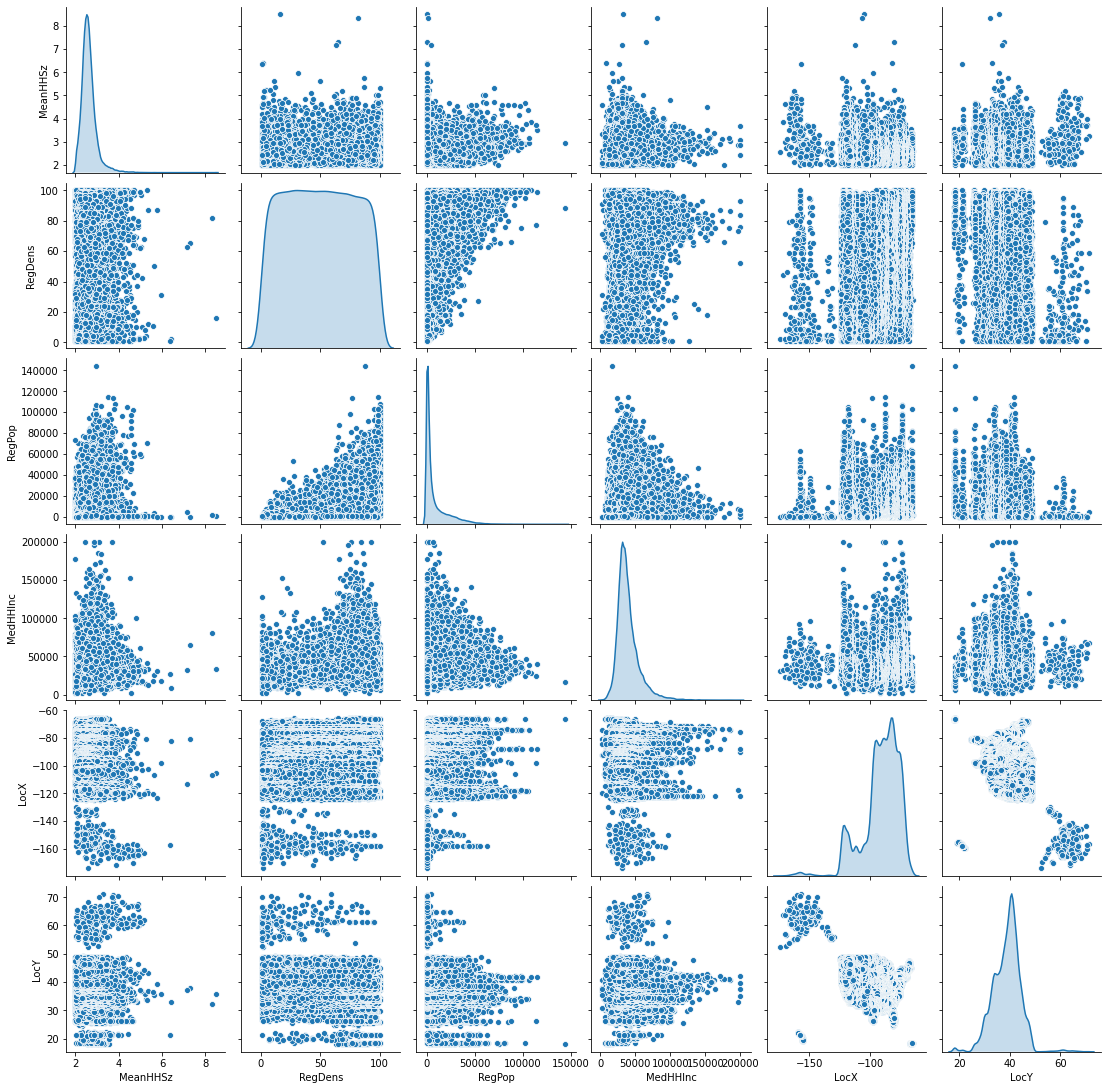

In [21]:
sns.pairplot(dfc_filtered_graph,diag_kind='kde')

In [12]:
dfc_filtered_graph.describe()

,MeanHHSz,RegDens,RegPop,MedHHInc,LocX,LocY
count,30899.000000,30899.000000,30899.000000,30899.000000,30899.000000,30899.000000
mean,2.618091,50.202207,8999.441244,39682.335286,-90.996743,38.867203
std,0.350701,28.414435,13154.755607,15938.201292,14.947017,5.332310
min,2.000000,1.000000,4.000000,2499.000000,-174.196289,17.964529
25%,2.410000,26.000000,813.000000,29931.000000,-97.107022,35.434452
50%,2.570000,50.000000,2808.000000,36250.000000,-88.340403,39.503383
75%,2.760000,75.000000,11953.000000,45686.000000,-80.426074,42.125882
max,8.490000,100.000000,144024.000000,200001.000000,-65.292575,71.299525


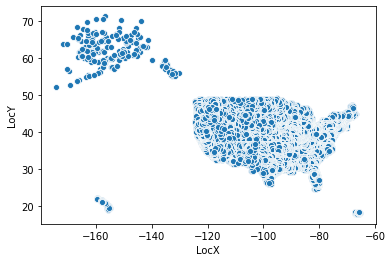

In [13]:
sns.scatterplot(dfc_filtered_graph.LocX, dfc_filtered_graph.LocY)

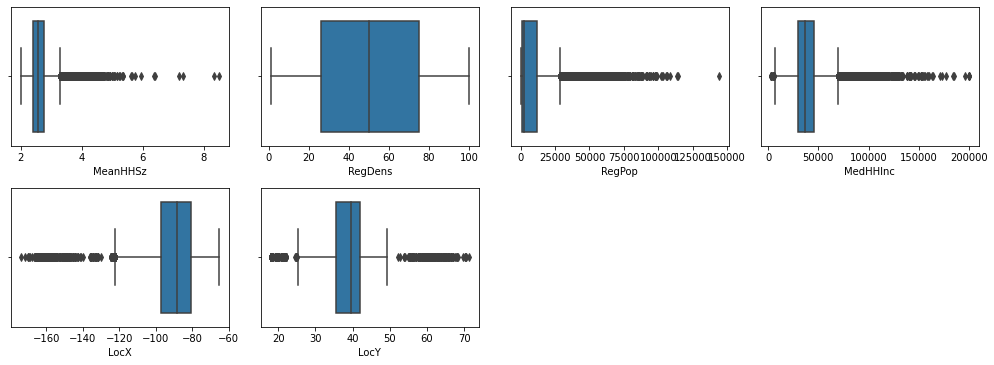

In [14]:
fig, ax = plt.subplots(figsize = (14, 50))
for i, col in enumerate(dfc_filtered_graph.columns):
    plt.subplot(20, 4, i+1)
    sns.boxplot(dfc_filtered_graph.iloc[:,i])
    plt.axis('on')
plt.tight_layout()

* ¿Qué nos están diciendo estos gráficos sobre los datos?
* ¿Aprecias normalidad de los datos? Genera un histograma con cada variable que consideres y revisa si ¿Tiene forma de campana?

In [14]:
# Se observa que el nivel de ingreso medio familiar (MedHHInc) ronda los 40.000 $, y que el tamaño medio
# de la unidad familiar (MeanHHSz) esta en torno a las 3 personas.

# La media de unidad familiar (MeanHHSz) se encuentra distribuida en todas las
# localizaciones sin tener en cuenta la densidad (RegDens), el ingreso (MedHHInc) y el total 
# de poblacion (RegPop)

# Excepto en la densidad de poblacion, se observan outliers en todas las demas caracteristicas

# Vemos en la diagonal los histogramas cruzados entre cada una de las 
# variables y todas menos excepto las de geolocalizacion  tienen un forma  de campana de gauss

# Los datos mas dispersos corresponden a Alaska, segun los datos de geolocalizacion

También puedes revisar la relación que existe entre las variables, la forma mas sencilla es mediante un gráfico de dispersión o calculando el coeficiente de correlación para revisar las relaciones lineales.

#### Algunos apuntes sobre el coeficiente de correlación
El [coeficiente de correlación ](https://es.wikipedia.org/wiki/Coeficiente_de_correlaci%C3%B3n_de_Pearson) es una medida del grado de *dependencia lineal* entre dos variables. El [coeficiente de correlación](https://es.wikipedia.org/wiki/Coeficiente_de_correlaci%C3%B3n_de_Pearson) oscila entre -1 y 1. Un valor de 1 significa que una [ecuación lineal](https://es.wikipedia.org/wiki/Ecuaci%C3%B3n_de_primer_grado) describe la relación entre las dos variables a la perfección, con todos los puntos de datos cayendo sobre una línea recta de pendiente positiva. Un valor de -1 implica que todos los puntos de datos se encuentran en una línea con pendiente negativa. Un valor de 0 implica que no existe una correlación lineal entre las variables. Lo podemos calcular con el método `corr`.

In [15]:
# coeficiente de correlación
dfc_filtered.corr()

,Numrow,LocX,LocY,RegDens,RegPop,MedHHInc,MeanHHSz
Numrow,1.000000,-0.888357,-0.043701,-0.279940,0.002020,-0.111858,0.143020
LocX,-0.888357,1.000000,-0.116894,0.254617,-0.015625,0.067608,-0.184683
LocY,-0.043701,-0.116894,1.000000,-0.161722,-0.180388,0.121010,-0.074380
RegDens,-0.279940,0.254617,-0.161722,1.000000,0.623130,0.367567,0.087272
RegPop,0.002020,-0.015625,-0.180388,0.623130,1.000000,0.202925,0.108856
MedHHInc,-0.111858,0.067608,0.121010,0.367567,0.202925,1.000000,0.154244
MeanHHSz,0.143020,-0.184683,-0.074380,0.087272,0.108856,0.154244,1.000000


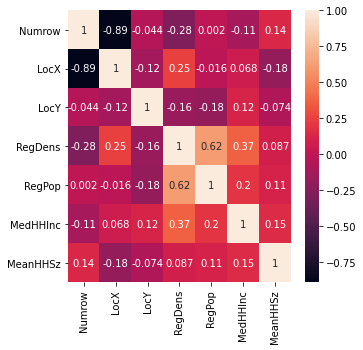

In [16]:
plt.figure(figsize=(5,5))
sns.heatmap(dfc_filtered.corr(),annot=True);

In [17]:
dfc_filtered_final = dfc_filtered[['LocX','LocY','RegDens','RegPop','MedHHInc','MeanHHSz']]

#### Recuerda también que correlación no implica causalidad.
Todo esto de la mala interpretación de la correlación también se encuentra, y en demasiadas ocasiones, en estudios científicos supuestamente serios. No son pocos los estudios que al encontrar una cierta relación entre dos variables presentes en los sujetos estudiados se tiran a la piscina afirmando que por tanto una de ellas es la causa de la otra, cuando en realidad en dichos estudios no hay ninguna evidencia de que esto sea verdad (simplemente hay correlación).

Echa un vistazo a este link y sorprendete con las "Spurious correlations"  http://tylervigen.com/spurious-correlations

<img src="correlacion.png" style="height: 150px">

## Transformación de variables

Una herramienta muy interesante a utilizar en aquellas variables que no cumplan con los criterios de normalidad es aplicar alguna transformación sobre las mismas, en particular el logaritmo funciona muy bien, y después de aplicarla confirma si los datos transformados se comportan como una normal.

Las ventajas de aplicar una transformación cuando la distribución de la variable no es normal son las siguientes:

* Que el efecto de posibles outliers sea menor.
* En algunos casos podría inducir normalidad, condición no necesaria, pero deseable.
* Que los rangos de las variables sean más comparables

<img src="logaritmo.png" style="height: 200px">

In [18]:
# Escalamos las variables con asimetrias notables
df_scaled = dfc_filtered_final.copy()
df_scaled['RegPop'] = np.log10(df_scaled['RegPop'])
df_scaled['MedHHInc'] = np.log10(df_scaled['MedHHInc'])
df_scaled['MeanHHSz'] = np.log10(df_scaled['MeanHHSz'])

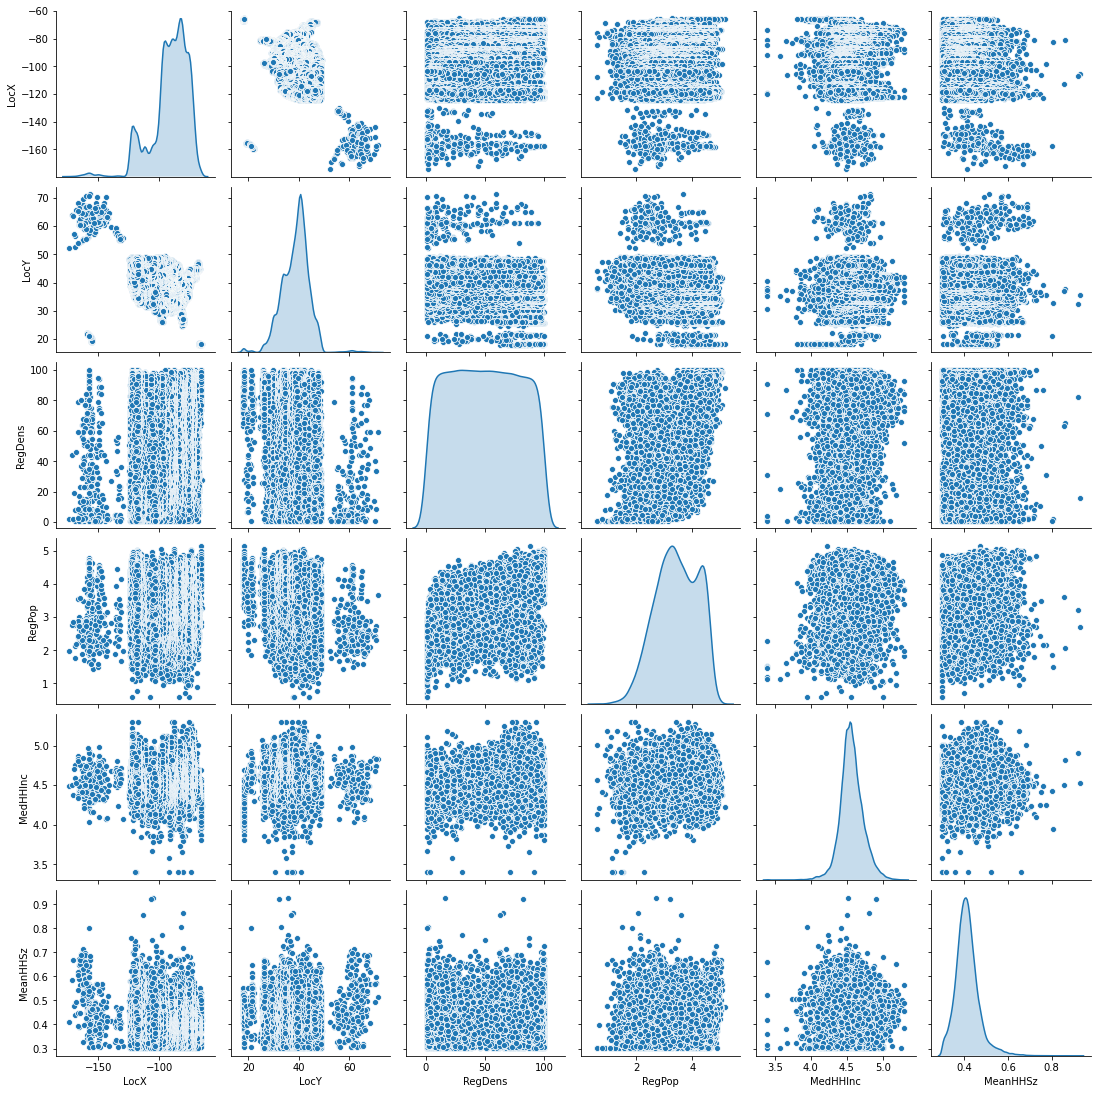

In [20]:
sns.pairplot(df_scaled, diag_kind='kde');

## Tratamiento de los datos, preprocessing

Respecto al tratamiento de datos, se llevarán a cabo las siguientes tareas:

* Imputación de missings.- la única variable que contiene valores missings es RegDens. Se predecirán sus valores a partir del resto de explicativas.

* Tratamiento de outliers.- se podrían filtras aquellas observaciones atípicas respecto de cada una de las variables. Hay que tener en cuenta que esto implicaría la pérdida de algunas regiones. 

* Alternativamente (para no perder registros) o de forma adicional, se puede aplicar una transformación a las variables con las ventajas ya mencionadas

## Imputación de valores ausentes
En los pasos anteriores hemos identificado los outliers y les hemos asignado a un valor nulo.

Ahora en este paso lo que vamos a hacer es darles un valor a los outliers para tener un dataset sin valores nulos y completar también si hay datos missing. Utiliza la técnica que consideres mas adecuada.

Recuerda que una opción es predecir los valores missing a partir de otras variables explicativas a través de una regresión.

Para mostrarte como realizar una regresión simple te incluyo un ejemplo a continuación.
En primer lugar generamos unos datos "casi aleatorios" que nos sirvan de ejemplo. Se trata de ajustar una línea que siga el modelo siguiente:
$$
y = ax + b
$$
donde $a$ es conocida como *slope* o *pendiente*, y $b$ es conocida como *intercept* o *constante*.

Consideramos los siguientes datos, que mostramos con gráfico de dispersión y que consiste en un modelo con pendiente 2 y constante -5:

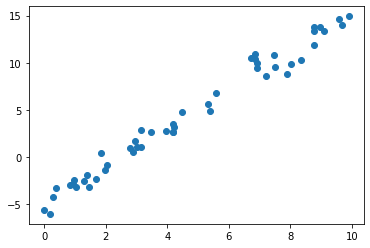

In [22]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);

Podemos utilizar el estimador Scikit-Learn's LinearRegression para ajustar los datos y construir la recta que mejor se ajusta:

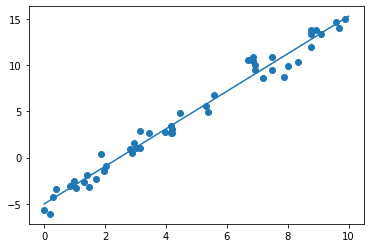

In [23]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

Y ya lo tenemos, la pendiente y la constante del modelo están en los parámetros fit, que como sabemos aparecen en Scikit-Learn marcados con un guión bajo.
Los parámetros relevantes son ``coef_`` y ``intercept_``. Y podemos utilizar cualquier nuevo dato de x para estimar y.

In [24]:
model.coef_

array([2.02720881])

In [25]:
model.intercept_

-4.998577085553204

In [ ]:
#y = 2.02720881 x  - -4.998577085553204 (Ecuacion de la recta para la regresion lineal)

* ¿Consideras que dispones ahora de un dataset mas adecuado para hacer un clustering? ¿Por qué?

In [27]:
# Si puesto que las distribuciones se ajustan mas a una normal

# Clustering jerárquico aglomerativo y kmeans

En esta parte queremos aplicar el método K-means ( y en particular kmeans ++) al dataset anterior con el objetivo de determinar los clusters mas adecuados para abrir tiendas e incluso la tipología de tiendas que consideremos mas apropiada para los diferentes clusters.

* Aunque existen otras técnicas, se recomienda aplicar un método de clusterización jerárquico aglomerativo en una primera etapa y a través del dendrograma seleccionar el número de clusters adecuado

* Posteriormente aplicamos kmeans sobre los clusters estimados por el metodo jerárquico.

<img src="dendrograma.png" width="50%">

Para que sea mas productivo, la recomendación es realizarlo de la siguiente forma:

* Primero seleccionar una submuestra de 100-200 registros para visualizar adecuadamente el dendrograma y de ahí extraer el número de clusters.
* Aplicar kmeans al número de clusters elegido previamente.

Si el resultado no fuese adecuado ejecutar kmeans variando el número de clusters de acuerdo a la información proporcionada por el dendrograma.

In [28]:
# Cojemos una submuestra, en este caso de 200 registros
df_sample = df_scaled.sample(n = 200, random_state=42)
df_sample

,LocX,LocY,RegDens,RegPop,MedHHInc,MeanHHSz
1378,-72.617894,43.577762,43.0,2.463893,4.593840,0.389166
19233,-95.090040,48.730013,7.0,2.925828,4.487845,0.401401
17912,-90.056601,43.783534,45.0,3.887223,4.548954,0.389166
17892,-90.269023,43.503482,25.0,3.160769,4.581210,0.419956
24382,-93.281947,30.921274,78.0,2.885361,4.426820,0.406540
...,...,...,...,...,...,...
32223,-120.424598,42.199446,11.0,3.701309,4.493820,0.380211
21979,-91.680755,40.526542,13.0,2.659916,4.508152,0.372912
31698,-122.207737,39.499754,31.0,3.946698,4.513031,0.442480
3149,-73.638011,42.685311,75.0,3.847264,4.751287,0.406540


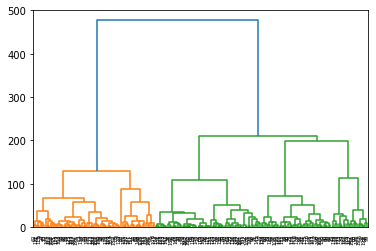

In [29]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
dendrogram = sch.dendrogram(sch.linkage(df_sample, method='ward'))

In [30]:
# DE ACUERDO AL DENDROGRAMA PARECE QUE SALEN 4 GRUPOS

hc = AgglomerativeClustering(n_clusters=4, affinity = 'euclidean', linkage = 'ward')
# salvamos los clusters para graficarlos
y_hc = hc.fit_predict(df_sample)
y_hc

array([3, 0, 3, 0, 2, 1, 3, 0, 0, 0, 3, 0, 3, 0, 1, 1, 2, 2, 3, 3, 0, 2,
       2, 3, 0, 0, 1, 0, 2, 3, 2, 2, 2, 1, 1, 0, 2, 0, 0, 2, 3, 2, 2, 0,
       2, 0, 0, 0, 0, 3, 3, 3, 3, 0, 2, 0, 1, 0, 1, 0, 3, 0, 0, 3, 3, 2,
       2, 2, 2, 2, 2, 0, 2, 0, 0, 3, 3, 2, 2, 0, 3, 2, 0, 1, 2, 2, 0, 0,
       0, 2, 2, 3, 2, 2, 3, 3, 3, 1, 0, 1, 0, 2, 0, 0, 0, 2, 3, 2, 3, 0,
       3, 0, 2, 2, 0, 0, 0, 1, 3, 2, 0, 3, 3, 0, 2, 0, 0, 1, 2, 2, 3, 2,
       0, 3, 0, 3, 2, 2, 0, 1, 2, 2, 2, 2, 1, 2, 0, 0, 0, 1, 3, 2, 1, 3,
       3, 0, 1, 2, 0, 0, 2, 0, 3, 3, 0, 2, 2, 2, 0, 2, 0, 3, 0, 2, 2, 1,
       3, 0, 3, 2, 2, 2, 3, 2, 0, 0, 0, 0, 1, 0, 1, 0, 0, 2, 0, 0, 0, 0,
       2, 1])

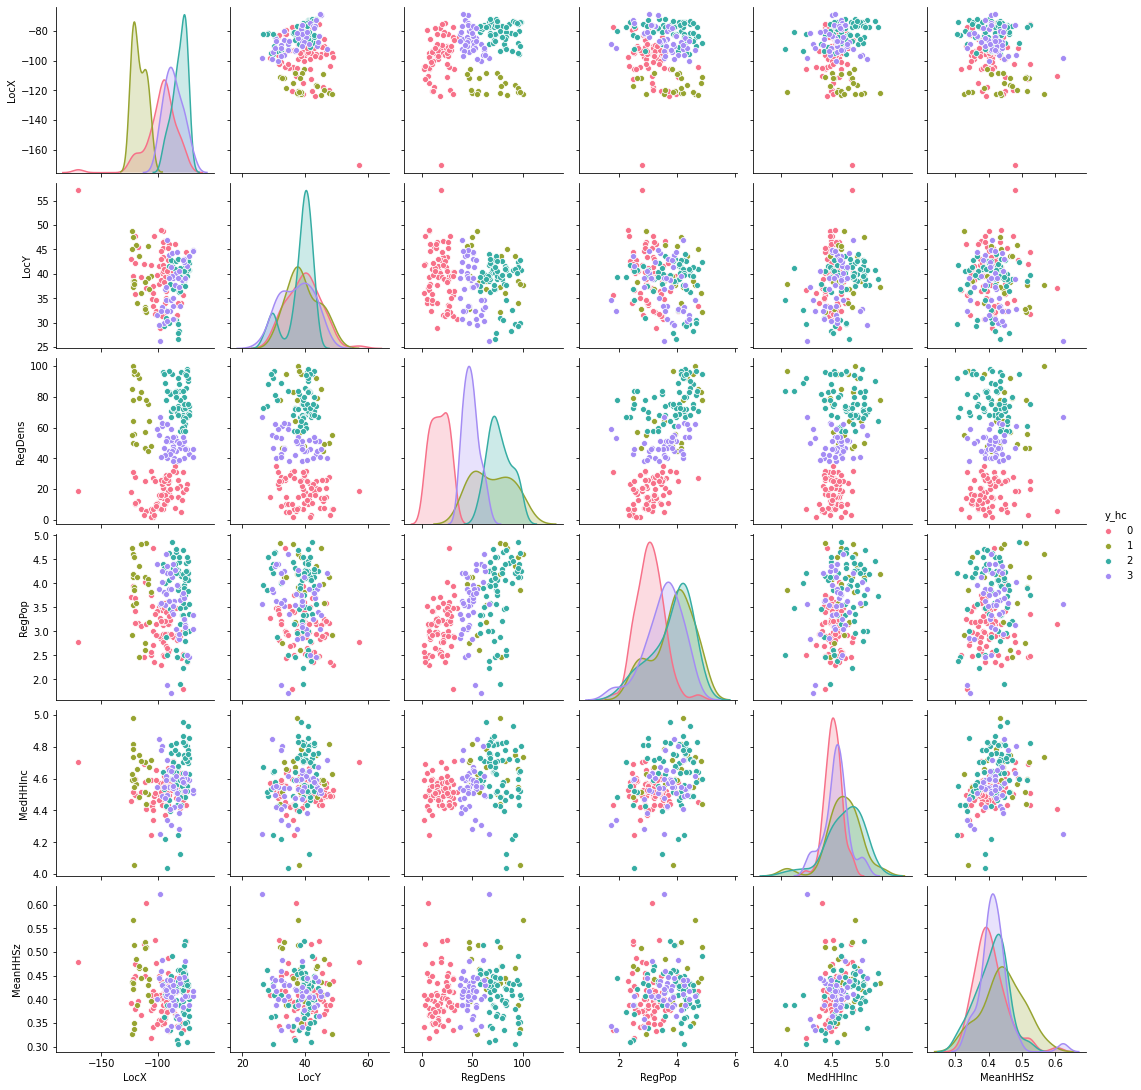

In [32]:
df_pairplot = df_sample.copy()
df_pairplot['y_hc']=y_hc
variables = ['LocX', 'LocY', 'RegDens', 'RegPop', 'MedHHInc', 'MeanHHSz']
colors = sns.color_palette("husl", 4)
sns.pairplot(df_pairplot, diag_kind='kde', hue='y_hc', vars=variables,  palette=colors);

In [ ]:
# RegDens es la que mejor separacion hace de los grupos.

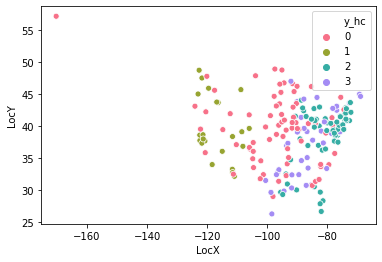

In [33]:
# Podemos visualizar estos puntos en el mapa
sns.scatterplot(x="LocX", y="LocY", data=df_pairplot, hue='y_hc', palette=colors )

# ¿Y si utilizas DBSCAN?

In [47]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
dbscan = DBSCAN(eps=7.0, 
                min_samples = 8,
                metric='euclidean')
clusters = dbscan.fit_predict(df_sample)
pd.Series(clusters2).value_counts()

# Me queda la clase 3 un poco desbalanceada, luego de probar varios valores de eps(maxima distancia entre dos muestras)


-1    95
 2    42
 0    42
 1    12
 3     9
dtype: int64

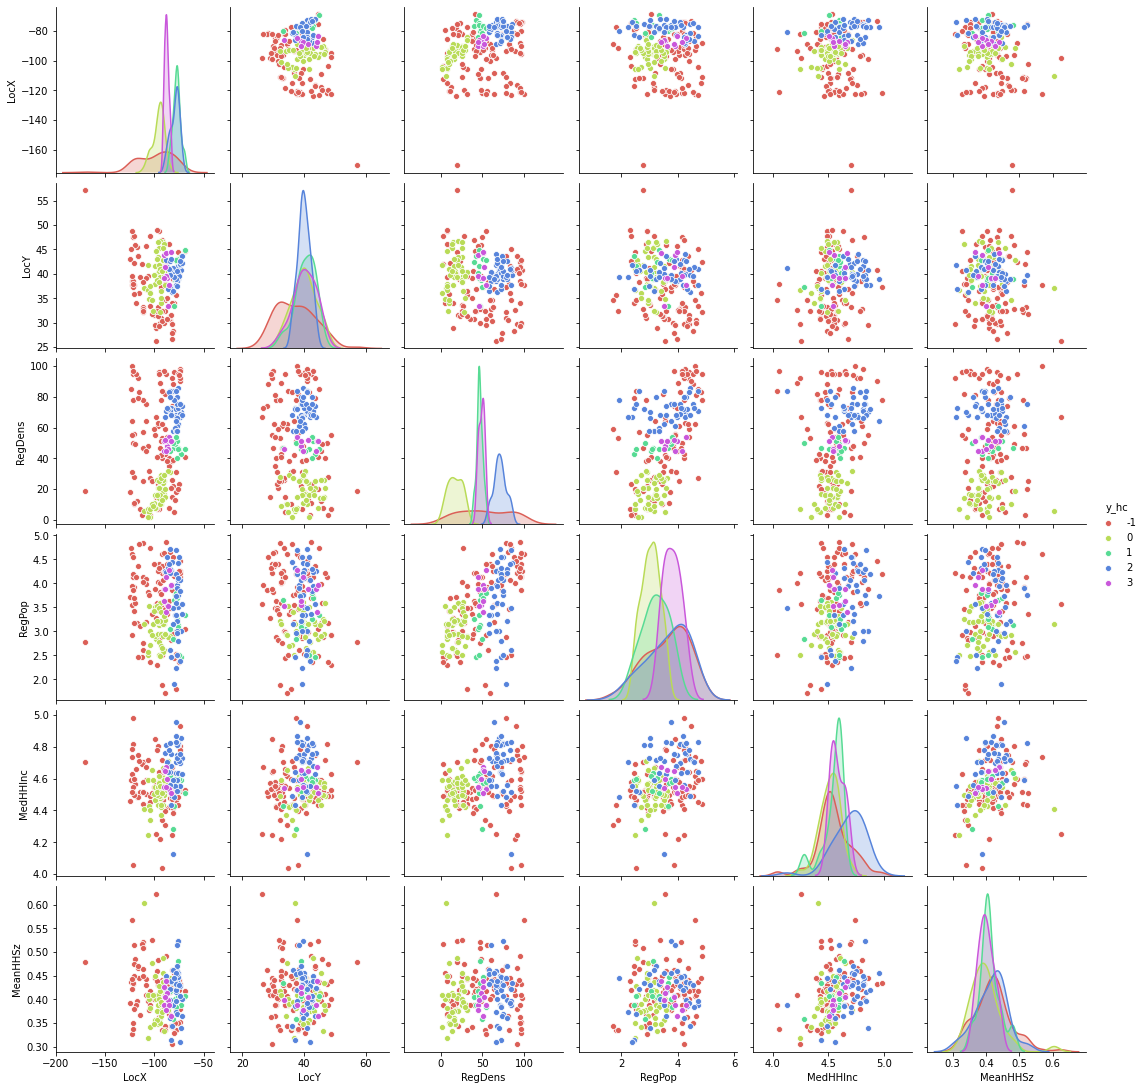

In [48]:
df_pairplot_dbscan = df_sample.copy()
df_pairplot_dbscan['y_hc']=clusters
variables = ['LocX', 'LocY', 'RegDens', 'RegPop', 'MedHHInc', 'MeanHHSz']
colors = sns.color_palette("hls", 5)
sns.pairplot(df_pairplot_dbscan, diag_kind='kde', hue='y_hc', vars=variables,  palette=colors);

In [ ]:
# Con DBSCAN tambien parece que RegDens es la que mejor separacion hace de los grupos.

# Perfiles de los clusters (profiling)

Una vez generados los clusters adecuados tenemos que analizar el pérfil de cada uno de los segmentos, utilizando las variables que tenemos disponibles.

El análisis de los pérfiles nos ayudará a establecer las conclusiones y las recomendaciones.

In [49]:
df_pairplot.groupby('y_hc', group_keys=True).agg(['max', 'min', 'mean'])

LocX                               LocY                        \
             max         min        mean        max        min       mean   
y_hc                                                                        
0     -74.449377 -170.272037  -97.171398  57.130894  28.972553  39.695127   
1    -105.979370 -123.019927 -116.374752  48.699642  32.128649  39.536487   
2     -72.123938  -95.517182  -80.686196  44.018871  26.634338  38.433695   
3     -68.919658 -100.519809  -86.079113  46.972432  26.249010  37.396392   

     RegDens                     RegPop                      MedHHInc  \
         max   min       mean       max       min      mean       max   
y_hc                                                                    
0       35.0   2.0  17.821918  4.725634  1.799341  3.064471  4.712860   
1      100.0  45.0  69.954545  4.848811  2.465383  3.874988  4.982624   
2       98.0  58.0  77.269841  4.863733  1.908485  3.800899  4.954816   
3       67.0  38.0  49.095238  4.600951  1.724276  3.545177  4.850236   

                          MeanHHSz                      
           min      mean       max       min      mean  
y_hc                                                    
0     4.243038  4.517328  0.604226  0.318063  0.406833  
1     4.059033  4.616576  0.567026  0.326336  0.443449  
2     4.034749  4.632921  0.523746  0.305351  0.409780  
3     4.253459  4.545216  0.623249  0.336460  0.416163

# Conclusiones y recomendaciones

* ¿Cuantos clusters has identificado?
* ¿Qué les caracteriza a cada uno de ellos?
* ¿Qué propuesta de tipología de tiendas propondrías?
* ¿Que otros factores tendrías en cuenta para diseñar un plan de expansión de tiendas?

In [ ]:
# A tenor del dendrograma podemos decir que cuatro seria el numero

# la variable RegDens es la que mejor separacion hace de los grupos

# 0 --> Poca densidad de poblacion (Casi todo el pais)
# 1 --> Densida media-alta de poblacion (Costa Oeste) 
# 2 --> Densidad alta poblacion (Costa Este)
# 3 --> Densidad media-baja de poblacion (Centro / Costa Este)

#